In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_MOUSE"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-VDJmouse-IGH_MOUSE-after-reassignment.csv']

In [3]:
pt_file="20230823-DataSheet-RUN52.csv"
run = "run52"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run52-similarity-IGH_MOUSE.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,A1-ERO-d21-blood-Bh_S45,nomatch,CARGEAMDYWGQGTSVT,256890,1,IGHV1-12,IGHJ4,585,0.002277,97.659354,0.632911
1,A1-ERO-d21-blood-Bh_S45,nomatch,CARGGAMDYWGQGTSVT,597,1,IGHV1-12,IGHJ4,3,0.005025,0.226956,0.632911
2,A1-ERO-d21-blood-Bh_S45,nomatch,CARGVAMDYWGQGTSVT,566,1,IGHV1-12,IGHJ4,0,0.000000,0.215171,0.632911
3,A1-ERO-d21-blood-Bh_S45,nomatch,CARGEAMDYWGQGASVT,478,1,IGHV1-12,IGHJ4,1,0.002092,0.181717,0.632911
4,A1-ERO-d21-blood-Bh_S45,nomatch,CARGEAMDYWGQGTPVT,458,1,IGHV1-12,IGHJ4,1,0.002183,0.174113,0.632911


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
1103399,BN1-ESRA-d90-LN-Bh_S88,YAMDYWGQGTSVT,1656,1,50,0.030193,1.865915,0.002042
1061723,BN1-ESRA-d90-LN-Bh_S88,CARDREDGYYAMDYWGQGTSVT,1203,1,4,0.003325,1.355493,0.002042
1066999,BN1-ESRA-d90-LN-Bh_S88,CARFYYDYAYFDVWGTGTTVT,473,1,2,0.004228,0.532958,0.002042
1074220,BN1-ESRA-d90-LN-Bh_S88,CARIGYLFDYWGQGTTLT,450,1,5,0.011111,0.507042,0.002042
1076425,BN1-ESRA-d90-LN-Bh_S88,CARLMTTRYFDVWGTGTTVT,410,1,2,0.004878,0.461972,0.002042


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,...,Species,Chain,Patient,SampleInfo,UMI,Constant,MID,HEK_cells,Group,RACE
0,N701_S502,AB-RTX56-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S1,...,human,TCRb,10-01-0003,V6_M12,yes,no,NaN,no,NaN,no
1,N702_S502,AB-RTX58-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,...,human,TCRb,10-01-0007,V6_M12,yes,no,NaN,no,NaN,no
2,N703_S502,AB-RTX59-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S3,...,human,TCRb,10-04-0007,V6_M12,yes,no,NaN,no,NaN,no
3,N704_S502,AB-RTX60-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S4,...,human,TCRb,40-01-0014,V6_M12,yes,no,NaN,no,NaN,no
4,N705_S502,AB-RTX61-Tu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S5,...,human,TCRb,40-01-0016,V6_M12,yes,no,NaN,no,NaN,no


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,AB-RTX56-Tu_S1,10-01-0003
1,AB-RTX58-Tu_S2,10-01-0007
2,AB-RTX59-Tu_S3,10-04-0007
3,AB-RTX60-Tu_S4,40-01-0014
4,AB-RTX61-Tu_S5,40-01-0016


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,BN1-ESRA-d90-LN-Bh_S88,YAMDYWGQGTSVT,1656,1,50,0.030193,1.865915,0.002042,BN1
1,BN1-ESRA-d90-LN-Bh_S88,CARDREDGYYAMDYWGQGTSVT,1203,1,4,0.003325,1.355493,0.002042,BN1
2,BN1-ESRA-d90-LN-Bh_S88,CARFYYDYAYFDVWGTGTTVT,473,1,2,0.004228,0.532958,0.002042,BN1
3,BN1-ESRA-d90-LN-Bh_S88,CARIGYLFDYWGQGTTLT,450,1,5,0.011111,0.507042,0.002042,BN1
4,BN1-ESRA-d90-LN-Bh_S88,CARLMTTRYFDVWGTGTTVT,410,1,2,0.004878,0.461972,0.002042,BN1


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                               A1                        \
Sample           A1-ERO-d21-blood-Bh_S45 A1-ESRA-d90-SP-Bh_S26   
cdr3pep                                                          
AAGAMDYWGQGTSVT                      0.0                   0.0   
AAMDYWGQGTSVT                        0.0                   0.0   
AARNYFDYWGQGTTLT                     0.0                   0.0   
AAYAMDYWGQGTSVT                      0.0                   0.0   
AAYWGQGTTLT                          0.0                   0.0   

Patient                                                             \
Sample           A1-ESRA-d90-blood-Bh_S13 A1-ESRO-d21-blood-Bh_S63   
cdr3pep                                                              
AAGAMDYWGQGTSVT                       0.0                      0.0   
AAMDYWGQGTSVT                         0.0                      0.0   
AARNYFDYWGQGTTLT                      0.0                      0.0   
AAYAMDYWGQGTSVT                       0.0                      0.0   
AAYWGQGTTLT                           0.0                      0.0   

Patient                                                          \
Sample           A1-VERO-d21-LN-Bh_S58 A1-VERO-d21-blood-Bh_S41   
cdr3pep                                                           
AAGAMDYWGQGTSVT                    0.0                      0.0   
AAMDYWGQGTSVT                      0.0                      0.0   
AARNYFDYWGQGTTLT                   0.0                      0.0   
AAYAMDYWGQGTSVT                    0.0                      0.0   
AAYWGQGTTLT                        0.0                      0.0   

Patient                               A2                        \
Sample           A2-ERO-d21-blood-Bh_S46 A2-ESRA-d90-SP-Bh_S27   
cdr3pep                                                          
AAGAMDYWGQGTSVT                      0.0                   0.0   
AAMDYWGQGTSVT                        0.0                   0.0   
AARNYFDYWGQGTTLT                     0.0                   0.0   
AAYAMDYWGQGTSVT                      0.0                   0.0   
AAYWGQGTTLT                          0.0                   0.0   

Patient                                                             ...  \
Sample           A2-ESRA-d90-blood-Bh_S14 A2-ESRO-d21-blood-Bh_S64  ...   
cdr3pep                                                             ...   
AAGAMDYWGQGTSVT                       0.0                      0.0  ...   
AAMDYWGQGTSVT                         0.0                      0.0  ...   
AARNYFDYWGQGTTLT                      0.0                      0.0  ...   
AAYAMDYWGQGTSVT                       0.0                      0.0  ...   
AAYWGQGTTLT                           0.0                      0.0  ...   

Patient                              B4                            \
Sample           B4-ESRA-d90-SP-Bh_S118 B4-ESRA-d90-blood-Bh_S116   
cdr3pep                                                             
AAGAMDYWGQGTSVT                     0.0                       0.0   
AAMDYWGQGTSVT                       0.0                       0.0   
AARNYFDYWGQGTTLT                    0.0                       0.0   
AAYAMDYWGQGTSVT                     0.0                       0.0   
AAYWGQGTTLT                         0.0                       0.0   

Patient                                                      B5  \
Sample           B4-Naive-d0-blood-Bh_S99 B5-ERA-d45-LN-Bh_S134   
cdr3pep                                                           
AAGAMDYWGQGTSVT                       0.0                   0.0   
AAMDYWGQGTSVT                         0.0                   0.0   
AARNYFDYWGQGTTLT                      0.0                   0.0   
AAYAMDYWGQGTSVT                       0.0                   0.0   
AAYWGQGTTLT                           0.0                   0.0   

Patient                                                              \
Sample           B5-ERA-d45-blood-Bh_S129 B5-ESRA-d45-blood-Bh_S103   
cdr3pep    

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                                               A1  \
Sample                           A1-ERO-d21-blood-Bh_S45   
Patient Sample                                             
A1      A1-ERO-d21-blood-Bh_S45                 1.000000   
        A1-ESRA-d90-SP-Bh_S26                   0.738454   
        A1-ESRA-d90-blood-Bh_S13                0.485769   
        A1-ESRO-d21-blood-Bh_S63                0.276589   
        A1-VERO-d21-LN-Bh_S58                   0.473853   

Patient                                                 \
Sample                           A1-ESRA-d90-SP-Bh_S26   
Patient Sample                                           
A1      A1-ERO-d21-blood-Bh_S45               0.738454   
        A1-ESRA-d90-SP-Bh_S26                 1.000000   
        A1-ESRA-d90-blood-Bh_S13              0.704076   
        A1-ESRO-d21-blood-Bh_S63              0.427198   
        A1-VERO-d21-LN-Bh_S58                 0.688251   

Patient                                                    \
Sample                           A1-ESRA-d90-blood-Bh_S13   
Patient Sample                                              
A1      A1-ERO-d21-blood-Bh_S45                  0.485769   
        A1-ESRA-d90-SP-Bh_S26                    0.704076   
        A1-ESRA-d90-blood-Bh_S13                 1.000000   
        A1-ESRO-d21-blood-Bh_S63                 0.665170   
        A1-VERO-d21-LN-Bh_S58                    0.977107   

Patient                                                    \
Sample                           A1-ESRO-d21-blood-Bh_S63   
Patient Sample                                              
A1      A1-ERO-d21-blood-Bh_S45                  0.276589   
        A1-ESRA-d90-SP-Bh_S26                    0.427198   
        A1-ESRA-d90-blood-Bh_S13                 0.665170   
        A1-ESRO-d21-blood-Bh_S63                 1.000000   
        A1-VERO-d21-LN-Bh_S58                    0.677767   

Patient                                                 \
Sample                           A1-VERO-d21-LN-Bh_S58   
Patient Sample                                           
A1      A1-ERO-d21-blood-Bh_S45               0.473853   
        A1-ESRA-d90-SP-Bh_S26                 0.688251   
        A1-ESRA-d90-blood-Bh_S13              0.977107   
        A1-ESRO-d21-blood-Bh_S63              0.677767   
        A1-VERO-d21-LN-Bh_S58                 1.000000   

Patient                                                    \
Sample                           A1-VERO-d21-blood-Bh_S41   
Patient Sample                                              
A1      A1-ERO-d21-blood-Bh_S45                  0.535493   
        A1-ESRA-d90-SP-Bh_S26                    0.764339   
        A1-ESRA-d90-blood-Bh_S13                 0.932167   
        A1-ESRO-d21-blood-Bh_S63                 0.609203   
        A1-VERO-d21-LN-Bh_S58                    0.914565   

Patient                                               A2  \
Sample                           A2-ERO-d21-blood-Bh_S46   
Patient Sample                                             
A1      A1-ERO-d21-blood-Bh_S45                 0.426061   
        A1-ESRA-d90-SP-Bh_S26                   0.628199   
        A1-ESRA-d90-blood-Bh_S13                0.911908   
        A1-ESRO-d21-blood-Bh_S63                0.743168   
        A1-VERO-d21-LN-Bh_S58                   0.926414   

Patient                                                 \
Sample                           A2-ESRA-d90-SP-Bh_S27   
Patient Sample                                           
A1      A1-ERO-d21-blood-Bh_S45               0.476902   
        A1-ESRA-d90-SP-Bh_S26                 0.693239   
        A1-ESRA-d90-blood-Bh_S13              0.979518   
        A1-ESRO-d21-blood-Bh_S63              0.674630   
        A1-VERO-d21-LN-Bh_S58                 0.988327   

Patient                                                    \
Sample                           A2-ESRA-d90-blood-Bh_S14   
Patient Sample                                        

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run52-similarity-IGH_MOUSE.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 4.710703896926294e-05
max value: 1.0
Wrote run52-similarity-IGH_MOUSE.pdf to disk


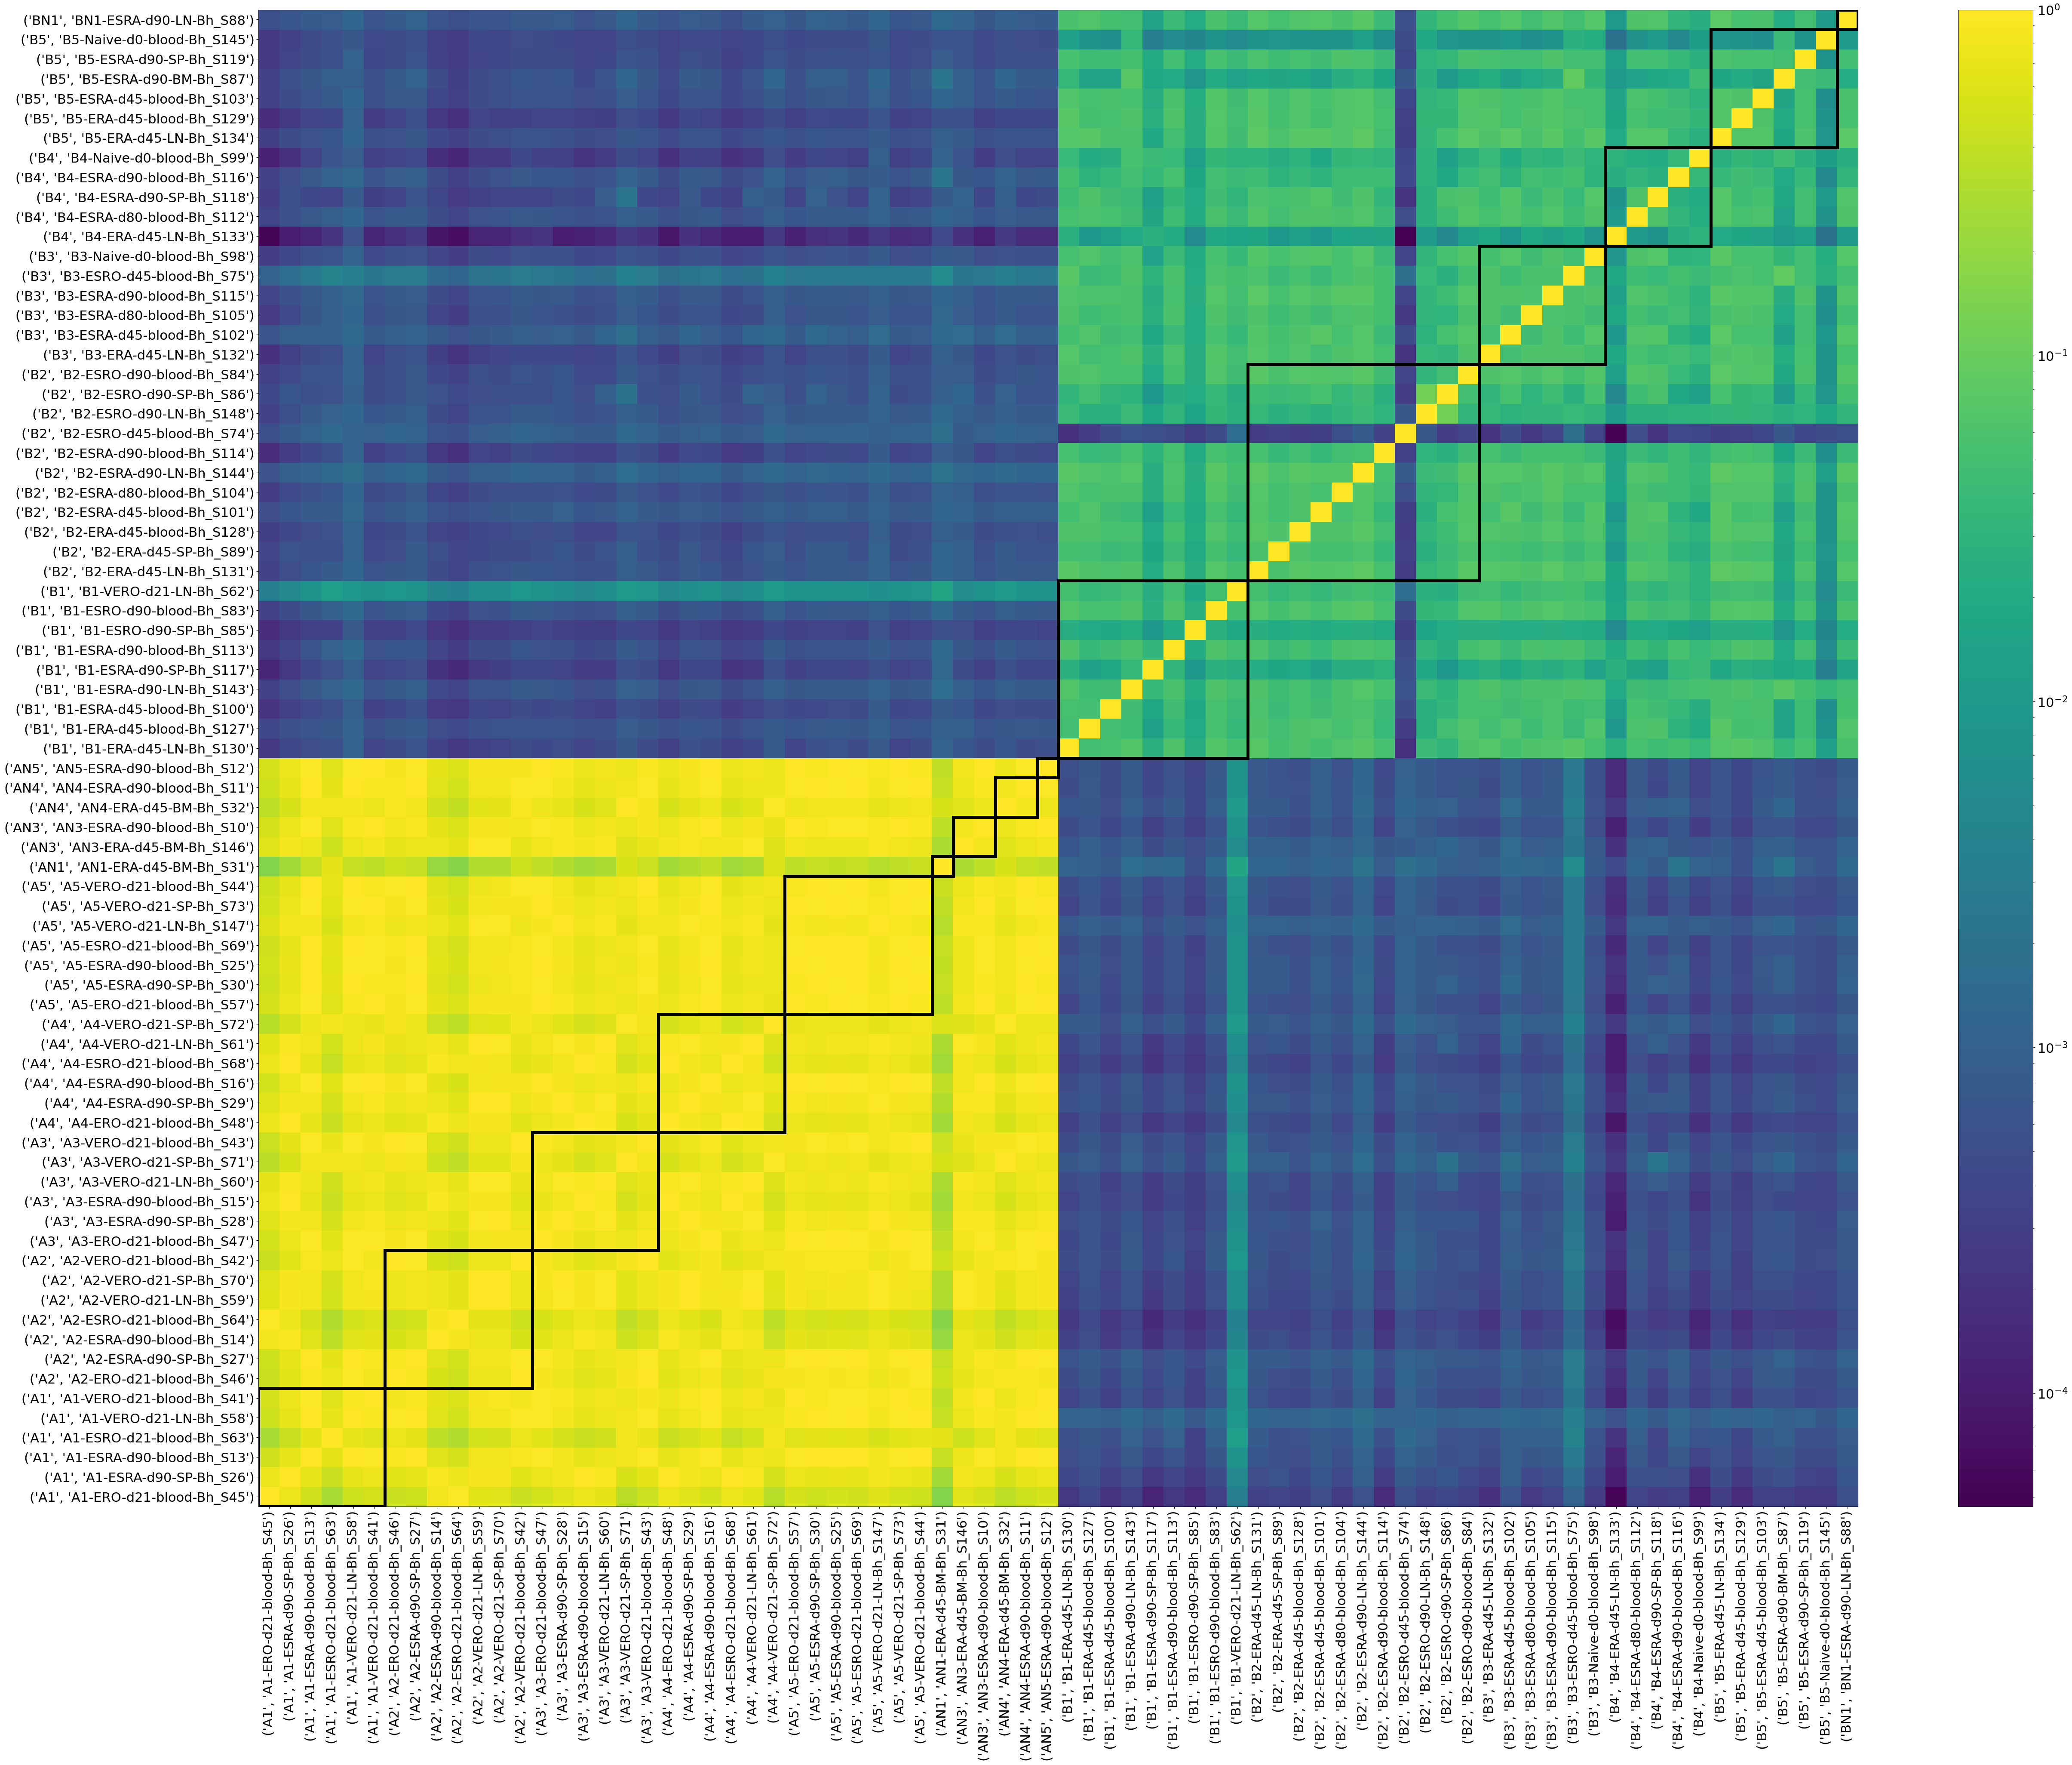

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.34095839530954103 0.37762949824500497
mean diff patient 0.18704246754225984 0.3285110535936233
threshold 1.5010866819167532


{'whiskers': [<matplotlib.lines.Line2D at 0x7f56194c4198>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56194c4748>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f561953ae10>,
 'medians': [<matplotlib.lines.Line2D at 0x7f56194c4cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f56194c4cc0>,
 'means': []}

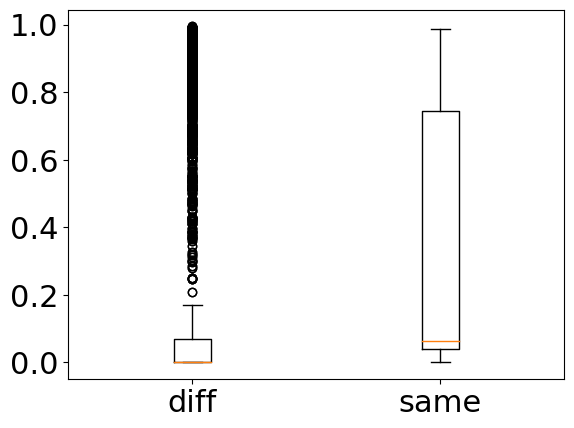

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

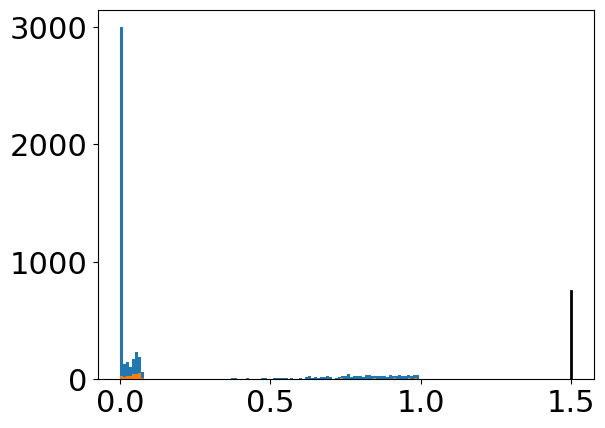

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

Wrote run52-similarity-IGH_MOUSE.txt to disk


In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 4.710703896926294e-05
max value: 1.0
Wrote run52-similarity-IGH_MOUSE-highlighted.pdf to disk


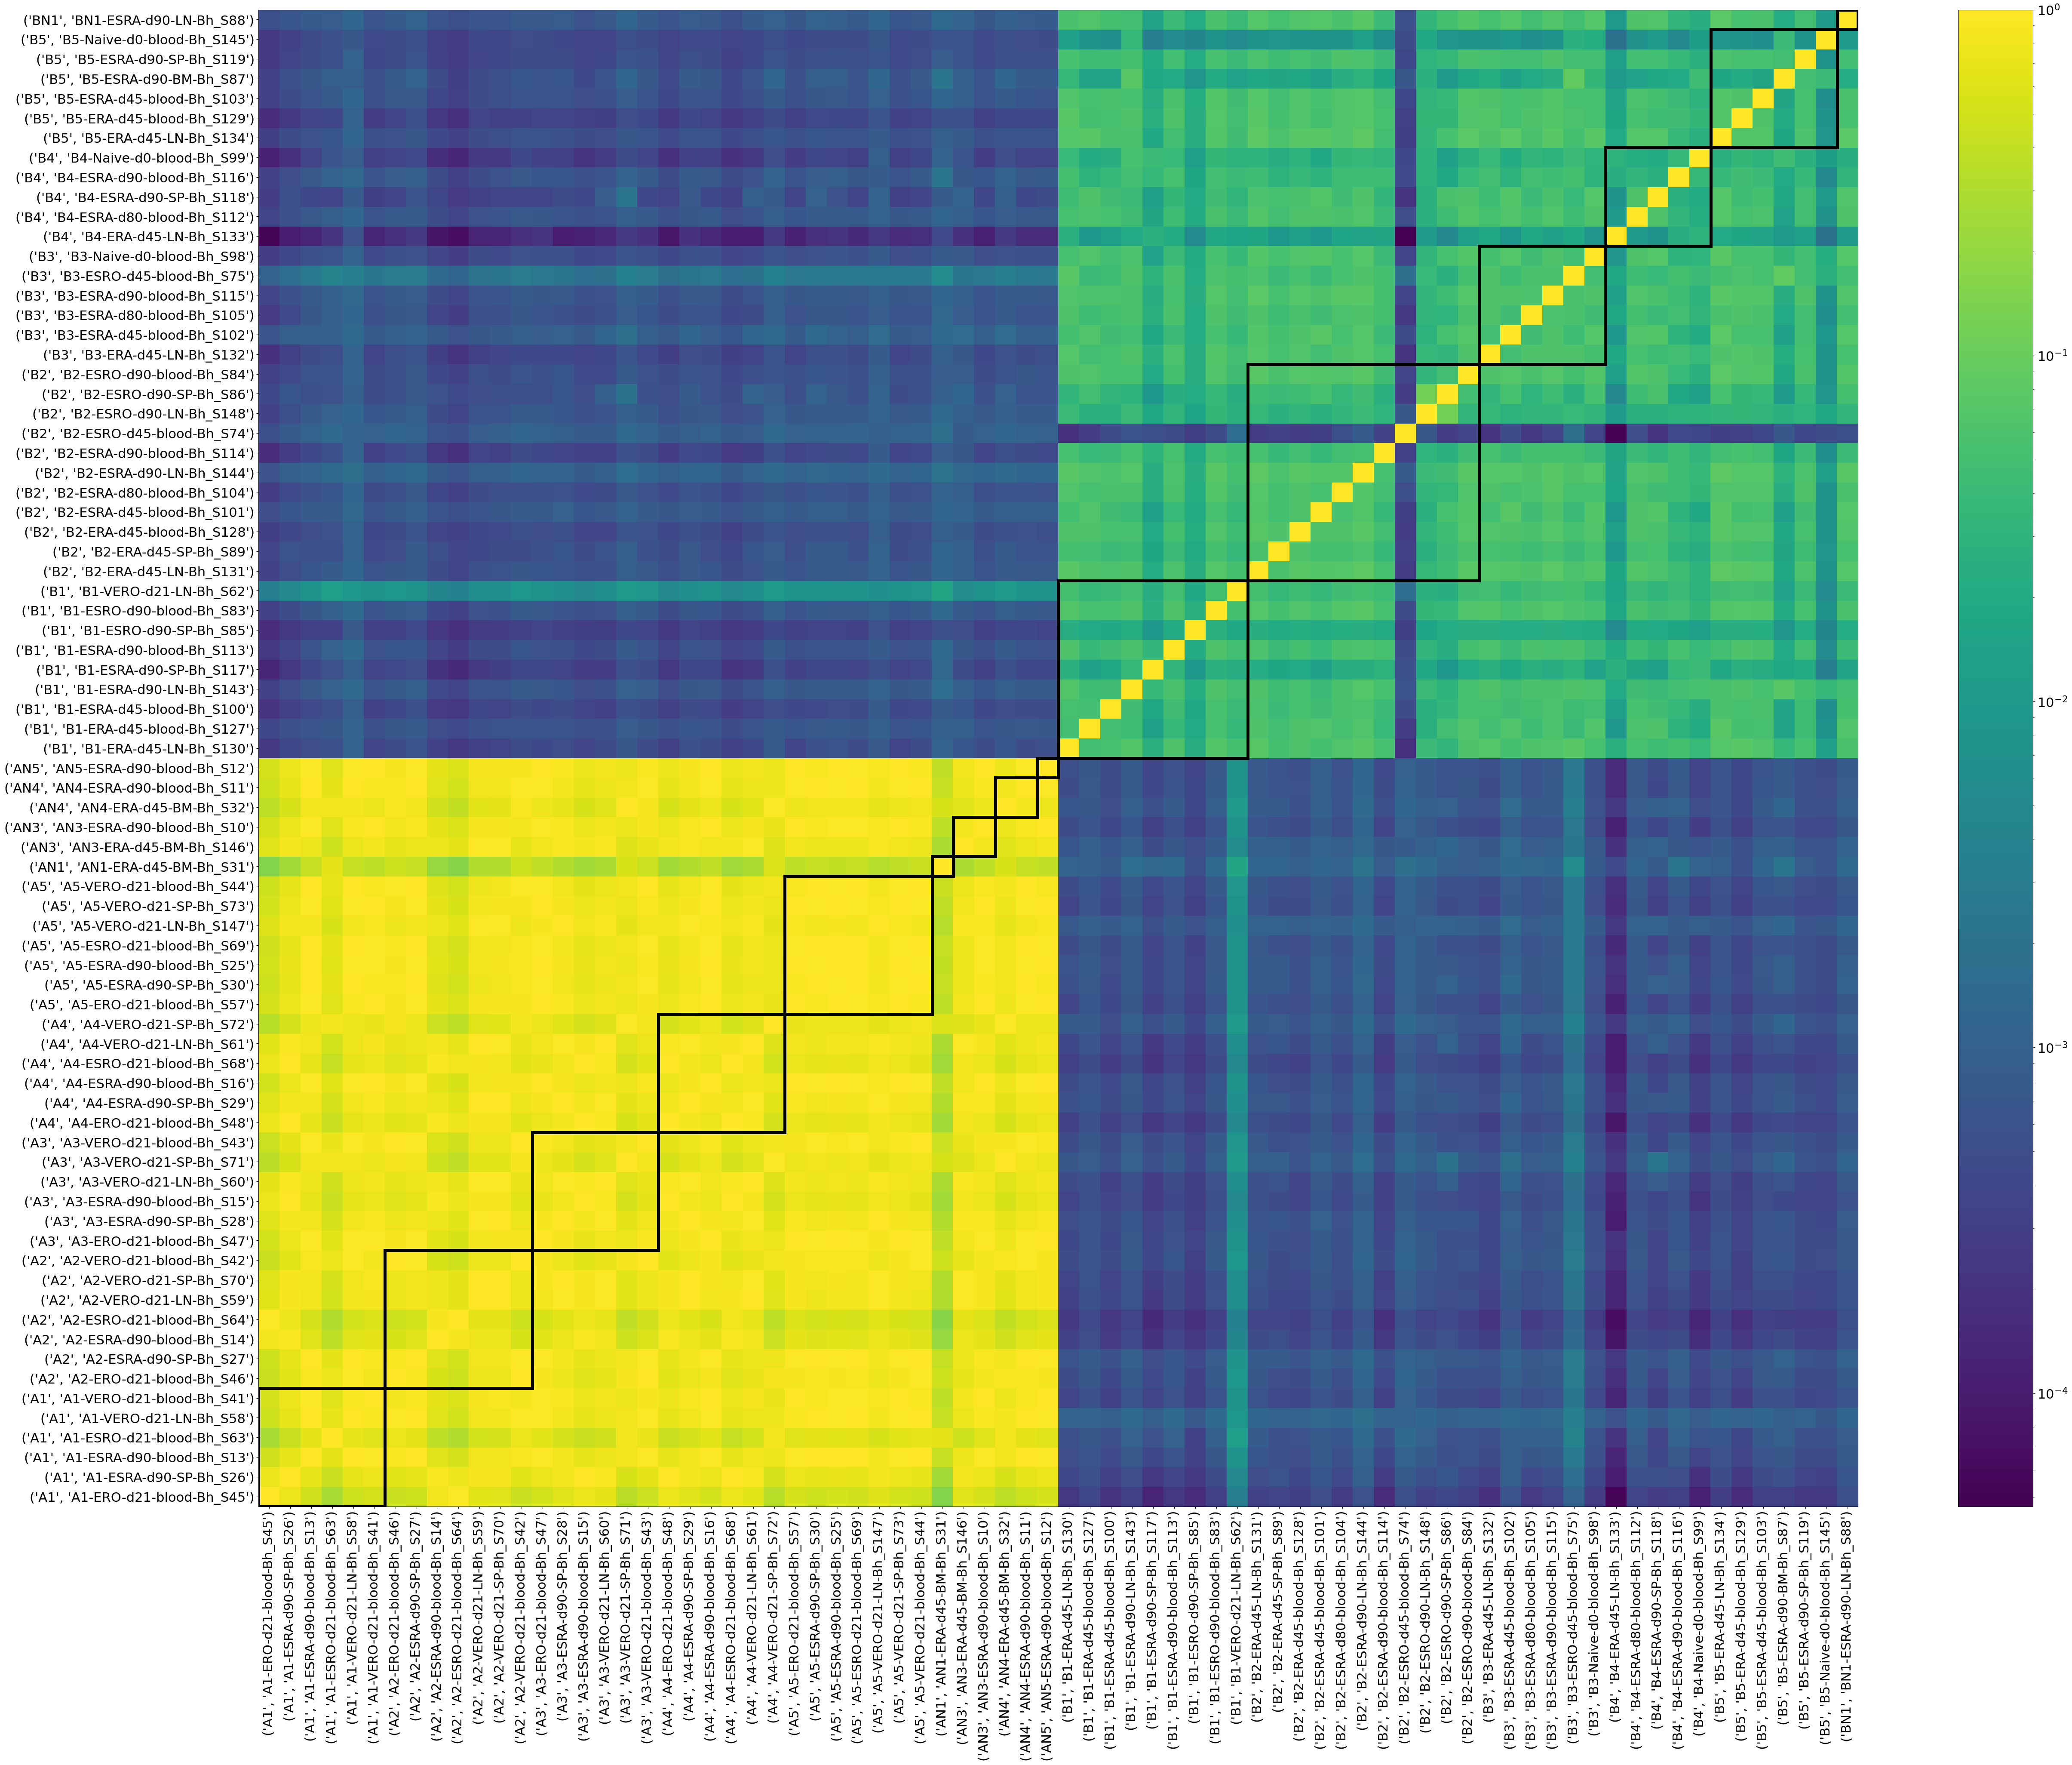

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)